#Group 15 - Project

Code in this notebook was referenced from some of the labs and also from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Number of training images:  639
Number of validation images:  211
Number of test images:  202


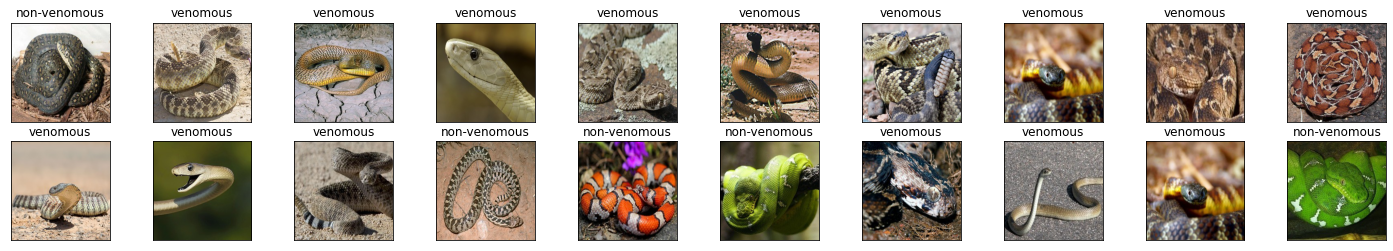

In [ ]:
# Loading Gesture Images from Google Drive

import torch
import numpy as np
import os

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# location on Google Drive
train_data = '/content/gdrive/My Drive/APS360/Colab Notebooks/Project/train'
val_data = '/content/gdrive/My Drive/APS360/Colab Notebooks/Project/val'
test_data = '/content/gdrive/My Drive/APS360/Colab Notebooks/Project/test'

# Transform Settings - Do not use RandomResizedCrop
transform = transforms.Compose([transforms.Resize((244,244)), transforms.ToTensor()])

# Load data from Google Drive
train = torchvision.datasets.ImageFolder(train_data, transform=transform)
val = torchvision.datasets.ImageFolder(val_data, transform=transform)
test = torchvision.datasets.ImageFolder(test_data, transform=transform)
n = len(val)  # total number of examples
non_venom = torch.utils.data.Subset(val, range(107))  # take first 50%
venom = torch.utils.data.Subset(val, range(107, n))  # take the rest

# Prepare Dataloader
batch_size = 32
num_workers = 1
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=True)
venom_loader = torch.utils.data.DataLoader(venom, batch_size=batch_size, num_workers=num_workers, shuffle=True)
non_venom_loader = torch.utils.data.DataLoader(non_venom, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#print("Total number of images: ", len(dataset))
print("Number of training images: ", len(train))
print("Number of validation images: ", len(val))
print("Number of test images: ", len(test))

classes = ['non-venomous', 'venomous']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class BaselineANN(nn.Module):
    def __init__(self):
        super(BaselineANN, self).__init__()
        self.layer1 = nn.Linear(244*244*3, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        x = img.view(-1, 244*244*3)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = x.squeeze(1)
        return x

baseline = BaselineANN()

In [ ]:
def evaluate(model, data):
    correct = 0
    total = 0
    
    for images, labels in data:
      images = images.cuda()
      labels = labels.cuda()
      prob = torch.sigmoid(model(images))
      for i in range(len(prob)):
        if (torch.argmax(prob[i]) == 0 and labels[i] == 0) or (torch.argmax(prob[i]) == 1 and labels[i] == 1):
          correct += 1
      total += images.shape[0]
    return correct / total

In [ ]:
def train_baseline(model, data, batch_size=32, rate=0.005, num_epochs=30, test=False):
    if(test == True):
      loader = test_loader
    else:
      loader = val_loader
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=rate)

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    iters = []

    # training
    n = 0 # the number of epochs
    for epoch in range(num_epochs):
      total_train_loss = 0.0
      total_train_err = 0.0
      total_epoch = 0
      for i, j in enumerate(data, 0):
          images, labels = j  
          out = model(images)             # forward pass
          labels = labels.type_as(out)
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch
          total_train_loss += loss.item()
          total_epoch += len(labels)

      train_acc[epoch] = evaluate(model, train_loader) #1 - (float(total_train_err) / total_epoch)
      train_loss[epoch] = float(total_train_loss) / (i+1)
      val_acc[epoch] = evaluate(model, loader)
      iters.append(n)
      n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    if(test == True):
       plt.plot(iters, val_acc, label="Test")
    else:
       plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if(test == True):
       print("Final Test Accuracy: {}".format(val_acc[-1]))
    else:
       print("Final Validation Accuracy: {}".format(val_acc[-1]))

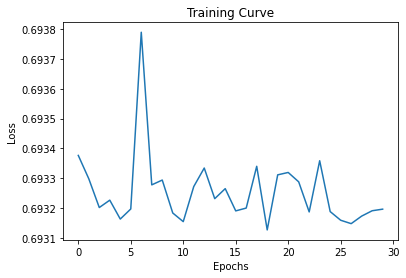

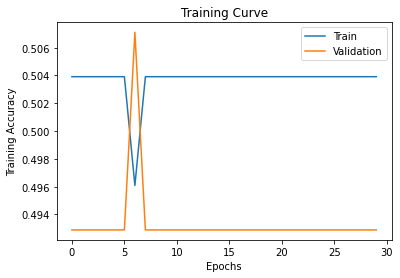

Final Training Accuracy: 0.5039123630672926
Final Validation Accuracy: 0.4928909952606635


In [ ]:
train_baseline(baseline, train_loader)

In [ ]:
#Convolutional Neural Network Setup

torch.manual_seed(1) # set the random seed

class SnakeCNN(nn.Module):
    def __init__(self):
        super(SnakeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #3 channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10*58*58, 32)
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*58*58)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

CNNmodel = SnakeCNN()

In [ ]:
def train_CNN(model, data, batch_size=32, rate=0.005, num_epochs=5, test=False):
    if(test == True):
      loader = test_loader
    else:
      loader = val_loader
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of epochs
    for epoch in range(num_epochs):
        for images, labels in data:
          
            if use_cuda and torch.cuda.is_available():
               images = images.cuda()
               labels = labels.cuda()
              
            out = model(images)             # forward pass
            labels = labels.type_as(out)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        #save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(evaluate(model, train_loader)) # compute training accuracy
        val_acc.append(evaluate(model, loader))  # compute validation accuracy
        n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    if(test == True):
      plt.plot(iters, val_acc, label="Test")
    else:
      plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if(test == True):
      print("Final Test Accuracy: {}".format(val_acc[-1]))
    else:
      print("Final Validation Accuracy: {}".format(val_acc[-1]))

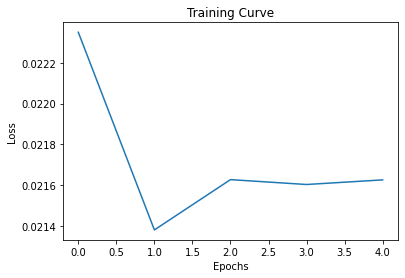

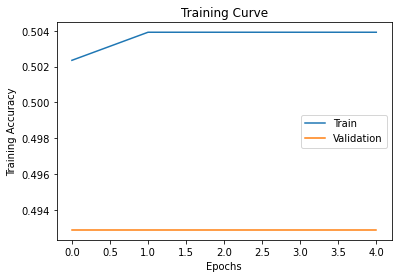

Final Training Accuracy: 0.5039123630672926
Final Validation Accuracy: 0.4928909952606635


In [ ]:
use_cuda = False
train_CNN(CNNmodel, train_loader)

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
data_dir = '/content/gdrive/My Drive/APS360/Colab Notebooks/Project'

# Number of classes in the dataset
num_classes = 2

# Models to choose from [resnet, alexnet, inception]
model_name = "resnet"

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(244),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    print(model_ft)

    return model_ft, input_size

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            #val_acc_history.append(epoch_acc)
            #loss_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_history

In [ ]:
# Initialize the model for this run
res_model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Send the model to GPU
res_model = res_model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = res_model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in res_model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in res_model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.01)

# Train and evaluate
res_model, reshist, resloss = train_model(res_model, dataloaders_dict, criterion, optimizer_ft, num_epochs=5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
# Models to choose from [resnet, alexnet, vgg, densenet, and squeezenet]
model_name = "alexnet"

# Initialize the model for this run
alex_model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Send the model to GPU
alex_model = alex_model.to(device)

params_to_update = alex_model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in alex_model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in alex_model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Train and evaluate
alex_model, alexhist, alexloss = train_model(alex_model, dataloaders_dict, criterion, optimizer_ft, num_epochs=5)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [ ]:
# Models to choose from [resnet, alexnet, vgg, densenet, and squeezenet]
model_name = "vgg"

# Initialize the model for this run
vgg_model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

criterion = nn.CrossEntropyLoss()

# Send the model to GPU
vgg_model = vgg_model.to(device)

params_to_update = vgg_model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in vgg_model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in vgg_model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Train and evaluate
vgg_model, vgghist, vggloss = train_model(vgg_model, dataloaders_dict, criterion, optimizer_ft, num_epochs=5)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(k

In [ ]:
# Models to choose from [resnet, alexnet, vgg, densenet, and squeezenet]
model_name = "densenet"

# Initialize the model for this run
dense_model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Send the model to GPU
dense_model = dense_model.to(device)

params_to_update = dense_model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in dense_model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in dense_model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Train and evaluate
dense_model, densehist, denseloss = train_model(dense_model, dataloaders_dict, criterion, optimizer_ft, num_epochs=5)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
# Models to choose from [resnet, alexnet, vgg, densenet, and squeezenet]
model_name = "squeezenet"

# Initialize the model for this run
squeeze_model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Send the model to GPU
squeeze_model = squeeze_model.to(device)

criterion = nn.CrossEntropyLoss()

params_to_update = squeeze_model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in squeeze_model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in squeeze_model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=0.001)

# Train and evaluate
squeeze_model, squeezehist, squeezeloss = train_model(squeeze_model, dataloaders_dict, criterion, optimizer_ft, num_epochs=5)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth



SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
  

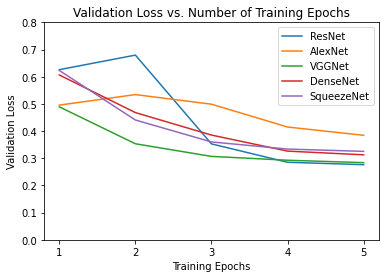

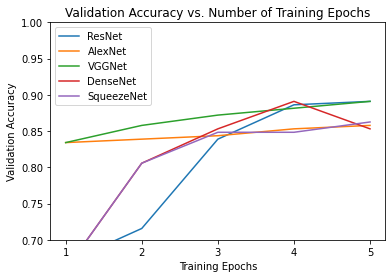

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
rhist = []
ahist = []
vhist = []
dhist = []
shist = []

rloss = []
aloss = []
vloss = []
dloss = []
sloss = []

rhist = [h.cpu().numpy() for h in reshist]
ahist = [h.cpu().numpy() for h in alexhist]
vhist = [h.cpu().numpy() for h in vgghist]
dhist = [h.cpu().numpy() for h in densehist]
shist = [h.cpu().numpy() for h in squeezehist]

rloss = [h for h in resloss]
aloss = [h for h in alexloss]
vloss = [h for h in vggloss]
dloss = [h for h in denseloss]
sloss = [h for h in squeezeloss]

plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1), rloss, label="ResNet")
plt.plot(range(1,num_epochs+1), aloss, label="AlexNet")
plt.plot(range(1,num_epochs+1), vloss, label="VGGNet")
plt.plot(range(1,num_epochs+1), dloss, label="DenseNet")
plt.plot(range(1,num_epochs+1), sloss, label="SqueezeNet")
plt.ylim((0,0.8))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1), rhist, label="ResNet")
plt.plot(range(1,num_epochs+1), ahist, label="AlexNet")
plt.plot(range(1,num_epochs+1), vhist, label="VGGNet")
plt.plot(range(1,num_epochs+1), dhist, label="DenseNet")
plt.plot(range(1,num_epochs+1), shist, label="SqueezeNet")
plt.ylim((0.7,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
print(evaluate(res_model, venom_loader))
print(evaluate(alex_model, venom_loader))
print(evaluate(vgg_model, venom_loader))
print(evaluate(dense_model, venom_loader))
print(evaluate(squeeze_model, venom_loader))

0.9615384615384616
0.9326923076923077
0.7403846153846154
0.7980769230769231
0.9807692307692307


In [ ]:
print(evaluate(res_model, non_venom_loader))
print(evaluate(alex_model, non_venom_loader))
print(evaluate(vgg_model, non_venom_loader))
print(evaluate(dense_model, non_venom_loader))
print(evaluate(squeeze_model, non_venom_loader))

0.5981308411214953
0.5420560747663551
0.8411214953271028
0.9158878504672897
0.38317757009345793


In [ ]:
print(evaluate(dense_model, test_loader))

0.8811881188118812


Total number of images:  100


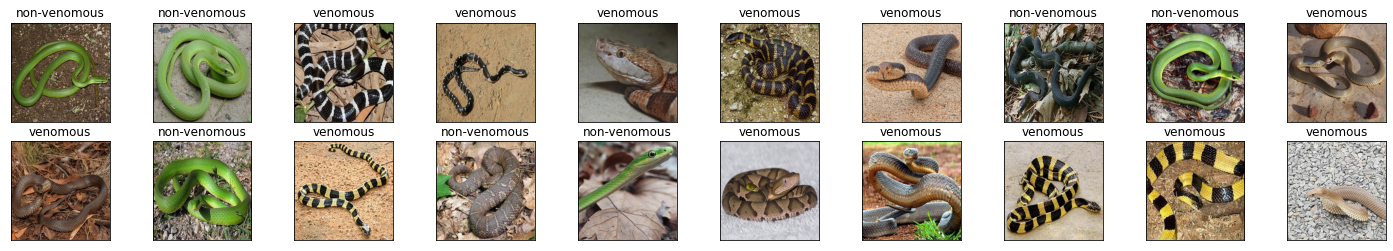

In [ ]:
demo_data = '/content/gdrive/My Drive/APS360/Colab Notebooks/Project/demo'
demo = torchvision.datasets.ImageFolder(demo_data, transform=transform)
demo_loader = torch.utils.data.DataLoader(demo, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of images
dataiter = iter(demo_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

print("Total number of images: ", len(demo))
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

0.58


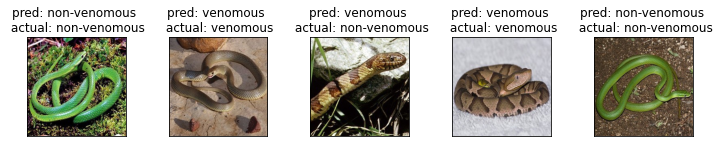

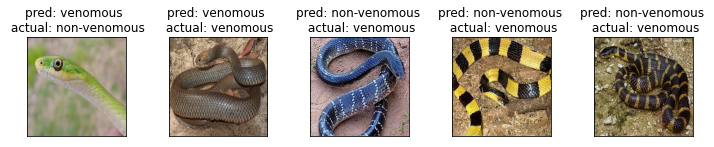

In [ ]:
print(evaluate(dense_model, demo_loader))

for i, (inputs, labels) in enumerate(demo_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = dense_model(inputs)
            _, preds = torch.max(outputs, 1)

            fig = plt.figure(figsize=(25, 4))
            for idx in range(5):
                ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
                plt.imshow(np.transpose(inputs[idx].cpu(), (1, 2, 0)))
                ax.set_title('pred: {} \n actual: {}'.format(classes[preds[idx]], classes[labels[idx]]))